In [24]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence, pack_padded_sequence
import random

from src.models.example_models import rae, vrae, iaf, test_data
from src.models.common import get_trained_model, get_loader

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Preparing some data for plots

In [25]:
random.seed(43)

n_test = 1000
x_test = next(iter(get_loader(test_data, n_test)))
target_padded, sequence_lengths = pad_packed_sequence(x_test)
target_averages = []
for i, length in enumerate(sequence_lengths):
    arr = target_padded[:,i][:length-1].numpy()
    target_averages.append(arr.mean())
    
batch_sizes = x_test.batch_sizes

num_emph = 4
emph_index = sorted(random.choices(range(len(test_data)), k=num_emph))
emph_packed = pack_padded_sequence( target_padded[:,emph_index,:], sequence_lengths[emph_index])

In [26]:
rae, t_info_rae = get_trained_model(rae, model_name="ToyRAE", training_info=True)
vrae, t_info_vrae = get_trained_model(vrae, model_name="ToyVRAE", training_info=True)
iaf, t_info_iaf = get_trained_model(iaf, model_name="ToyIAF", training_info=True)

# Recurrent Autoencoder

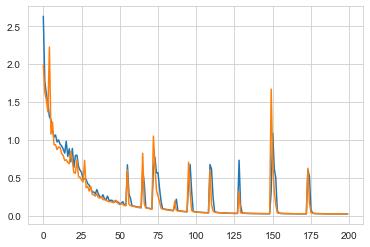

In [27]:
plt.plot(t_info_rae["training_loss"])
plt.plot(t_info_rae["validation_loss"])
plt.show()

Some encoded/decoded examples:

In [28]:
output_rae = rae(x_test)
latent_rae = rae.encoder(x_test)

<AxesSubplot:>

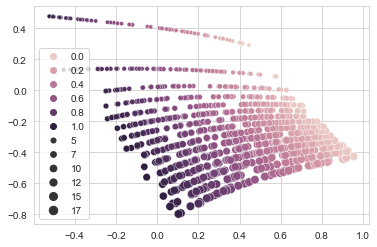

In [29]:
sns.scatterplot(
    x=latent_rae[:,0].detach().numpy(),
    y=latent_rae[:,1].detach().numpy(),
    size=sequence_lengths.numpy(),
    hue=target_averages,
    )

In [30]:
latent_rae[emph_index,0]

tensor([ 0.7355,  0.8228,  0.5779, -0.0938], grad_fn=<IndexBackward>)

<AxesSubplot:>

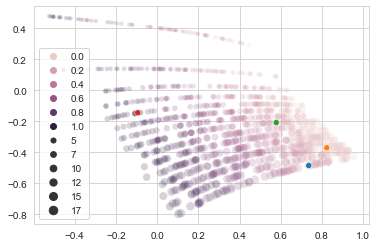

In [31]:
sns.scatterplot(
    x=latent_rae[:,0].detach().numpy(),
    y=latent_rae[:,1].detach().numpy(),
    size=sequence_lengths.numpy(),
    hue=target_averages,
    alpha=0.2,
    )
sns.scatterplot(
    x=latent_rae[emph_index,0].detach().numpy(),
    y=latent_rae[emph_index,1].detach().numpy(),
    c=[f"C{k}" for k in range(num_emph)]
)

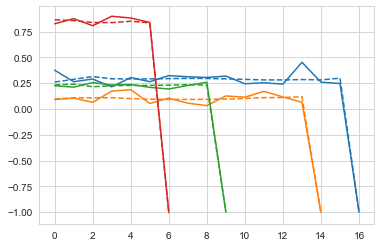

In [32]:
reconstrued_rae_padded, _ = pad_packed_sequence(output_rae)

for k, i in enumerate(emph_index):

    decoded_rae = reconstrued_rae_padded[:, i][:sequence_lengths[i]]
    target = target_padded[:, i][:sequence_lengths[i]]
    
    plt.plot(decoded_rae.detach().numpy(), color = f'C{k}', linestyle='dashed')
    plt.plot(target.detach().numpy(), color = f'C{k}')


# Variational recurrent autoencoder

## Training information

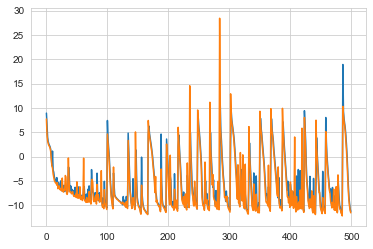

In [33]:
plt.plot(t_info_vrae["training_loss"])
plt.plot(t_info_vrae["validation_loss"])
plt.show()

In [34]:
output_vrae = vrae(x_test)
output_vrae_emph = vrae(emph_packed)
latent_sample_vrae = output_vrae['qz'].sample()
latent_emph_samples_vrae = torch.stack([output_vrae_emph['qz'].sample() for i in range(10_000)])
observation_sample_vrae = output_vrae['px'].sample()

<AxesSubplot:>

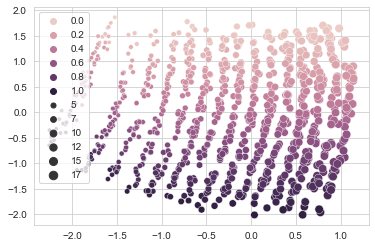

In [35]:
sns.scatterplot(
    x=latent_sample_vrae[:,0].numpy(),
    y=latent_sample_vrae[:,1].numpy(),
    size=sequence_lengths.numpy(),
    hue=target_averages,
)

<AxesSubplot:>

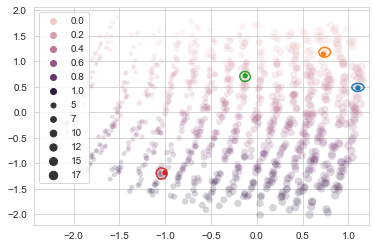

In [37]:
sns.scatterplot(
    x=latent_sample_vrae[:,0].detach().numpy(),
    y=latent_sample_vrae[:,1].detach().numpy(),
    size=sequence_lengths.numpy(),
    hue=target_averages,
    alpha=0.2,
    )

for i in range(num_emph):
    sns.kdeplot(
        x=latent_emph_samples_vrae[:, i, 0],
        y=latent_emph_samples_vrae[:, i, 1],
        levels=2
    )
    
sns.scatterplot(
    x=latent_sample_vrae[emph_index,0].detach().numpy(),
    y=latent_sample_vrae[emph_index,1].detach().numpy(),
    c=[f"C{k}" for k in range(num_emph)],
    markers="x",
)



## Reconstructed sequences

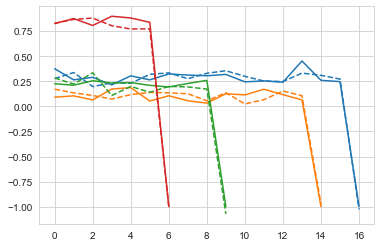

In [38]:
observation_sample_vrae_packed = PackedSequence(
    observation_sample_vrae,
    batch_sizes,
)
observation_sample_vrae_packed, _ = pad_packed_sequence(observation_sample_vrae_packed)

for k, i in enumerate(emph_index):

    decoded_vrae = observation_sample_vrae_packed[:, i][:sequence_lengths[i]]
    target = target_padded[:, i][:sequence_lengths[i]]
    
    plt.plot(decoded_vrae.detach().numpy(), color = f'C{k}', linestyle='dashed')
    plt.plot(target.detach().numpy(), color = f'C{k}')


## 

# IAF Variational Recurrent Autoencoder

(-6.0, 20.0)

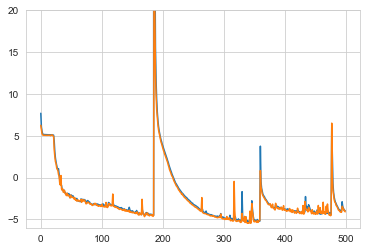

In [99]:
plt.plot(t_info_iaf["training_loss"])
plt.plot(t_info_iaf["validation_loss"])
plt.ylim(-6, 20)

In [56]:
output_iaf = iaf(x_test)
output_iaf_emph = iaf(emph_packed)
latent_sample_iaf = output_iaf['z'].detach()
latent_emph_samples_iaf = torch.stack([iaf(emph_packed)['z'] for i in range(10_000)])
observation_sample_iaf = output_iaf['px'].sample()

<AxesSubplot:>

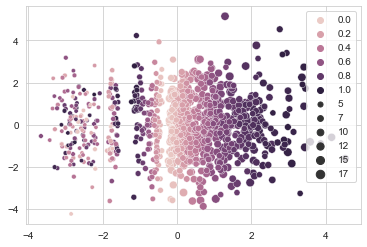

In [58]:
sns.scatterplot(
    x=latent_sample_iaf[:,0].numpy(),
    y=latent_sample_iaf[:,1].numpy(),
    size=sequence_lengths.numpy(),
    hue=target_averages,
)

<AxesSubplot:>

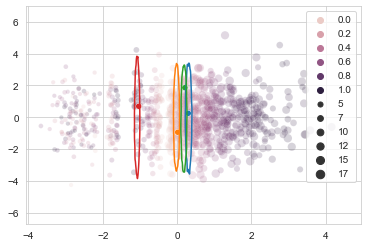

In [62]:
sns.scatterplot(
    x=latent_sample_iaf[:,0].detach().numpy(),
    y=latent_sample_iaf[:,1].detach().numpy(),
    size=sequence_lengths.numpy(),
    hue=target_averages,
    alpha=0.2,
    )

for i in range(num_emph):
    sns.kdeplot(
        x=latent_emph_samples_iaf[:, i, 0].detach().numpy(),
        y=latent_emph_samples_iaf[:, i, 1].detach().numpy(),
        levels=2
    )
    
sns.scatterplot(
    x=latent_sample_iaf[emph_index,0].detach().numpy(),
    y=latent_sample_iaf[emph_index,1].detach().numpy(),
    c=[f"C{k}" for k in range(num_emph)],
    markers="x",
)

